In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
raw_df = pd.read_csv('./generalAccuracy_combined.csv.bz2', index_col=0)

#basic_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_basicMethods_evaluated.csv')
#GNN_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_GNNRank_reTrained_syncRank_evaluated.csv')
#full_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_basicMethods_fullDataset_evaluated.csv')
#full_GNN_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_GNNRank_fullDataset_evaluated.csv')
#full_df['iteration'] = 500
#full_GNN_df['iteration'] = 500
#raw_df = pd.concat([basic_df, GNN_df, full_df, full_GNN_df])

#raw_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_basicMethods_stratified_evaluated.csv')

#raw_df = basic_df
#raw_df['bias_applied'] = True
raw_df = raw_df.rename(columns={'sampling strategy': 'sampling method', 'recovery method': 'Ranking Method'})

fairPR_df = raw_df[raw_df['Ranking Method'] == 'fairPageRank'].copy()
fairPR_df = fairPR_df.replace({'fairPageRank': 'Fairness-Aware PageRank\n(not post-processed)'})
#raw_df = pd.read_csv('./data/post_processing/EPIRA_10trials.csv')
raw_df = pd.read_csv('./data/post_processing/EPIRA99_10trials.csv')
#raw_df = pd.read_csv('./data/post_processing/FAstarIR_10trials.csv')
#raw_df = pd.read_csv('./data/post_processing/FAstarIRp60_10trials.csv')
#raw_df = pd.read_csv('./data/post_processing/IMDB-WIKI_EPIRA99_10trials_v2.csv')

#raw_df['bias_applied'] = True
raw_df = raw_df.rename(columns={'sampling strategy': 'sampling method', 'recovery method': 'Ranking Method'})
raw_df = pd.concat([raw_df, fairPR_df])

raw_df

,trial,iteration,value,bias_applied,sampling method,Ranking Method,metric,group
0,0,40,0.311896,False,RandomSampling,davidScore,tau,Overall
1,0,40,0.321768,False,RandomSampling,davidScore,tau,Privileged
2,0,40,0.300549,False,RandomSampling,davidScore,tau,Unprivileged
3,0,40,0.341602,False,RandomSampling,davidScore,tau,Privileged within-group
4,0,40,0.310811,False,RandomSampling,davidScore,tau,Between groups
...,...,...,...,...,...,...,...,...
213627,9,3000,0.114268,False,RankSampling,Fairness-Aware PageRank\n(not post-processed),tau,Privileged within-group
213628,9,3000,0.119318,False,RankSampling,Fairness-Aware PageRank\n(not post-processed),tau,Between groups
213629,9,3000,0.121810,False,RankSampling,Fairness-Aware PageRank\n(not post-processed),tau,Unprivileged within-group
213630,9,3000,0.151526,False,RankSampling,Fairness-Aware PageRank\n(not post-processed),exposure,Privileged


In [29]:
sel_df = raw_df[raw_df.iteration == 500]
sel_df = sel_df.groupby(['iteration','bias_applied','sampling method','metric','group','Ranking Method']).mean().reset_index()
sel_df.loc[sel_df.metric == 'exposure', 'exposure'] = sel_df.value
sel_df.loc[sel_df.metric == 'tau', 'tau'] = sel_df.value
sel_df

,iteration,bias_applied,sampling method,metric,group,Ranking Method,trial,value,exposure,tau
0,500,False,OversampleMinority,exposure,Privileged,Fairness-Aware PageRank\n(not post-processed),4.5,0.149501,0.149501,NaN
1,500,False,OversampleMinority,exposure,Privileged,GNNRank,4.5,0.147803,0.147803,NaN
2,500,False,OversampleMinority,exposure,Privileged,davidScore,4.5,0.147503,0.147503,NaN
3,500,False,OversampleMinority,exposure,Privileged,randomRankRecovery,4.5,0.147923,0.147923,NaN
4,500,False,OversampleMinority,exposure,Privileged,rankCentrality,4.5,0.147489,0.147489,NaN
...,...,...,...,...,...,...,...,...,...,...
235,500,True,RankSampling,tau,Unprivileged within-group,Fairness-Aware PageRank\n(not post-processed),4.5,0.263578,NaN,0.263578
236,500,True,RankSampling,tau,Unprivileged within-group,GNNRank,4.5,0.282014,NaN,0.282014
237,500,True,RankSampling,tau,Unprivileged within-group,davidScore,4.5,0.458943,NaN,0.458943
238,500,True,RankSampling,tau,Unprivileged within-group,randomRankRecovery,4.5,0.718686,NaN,0.718686


In [30]:
priv_df = sel_df[sel_df.group == 'Privileged'].drop(columns=['iteration', 'trial', 'value'])
unpriv_df = sel_df[sel_df.group == 'Unprivileged'].drop(columns=['iteration', 'trial', 'value'])
priv_df

,bias_applied,sampling method,metric,group,Ranking Method,exposure,tau
0,False,OversampleMinority,exposure,Privileged,Fairness-Aware PageRank\n(not post-processed),0.149501,NaN
1,False,OversampleMinority,exposure,Privileged,GNNRank,0.147803,NaN
2,False,OversampleMinority,exposure,Privileged,davidScore,0.147503,NaN
3,False,OversampleMinority,exposure,Privileged,randomRankRecovery,0.147923,NaN
4,False,OversampleMinority,exposure,Privileged,rankCentrality,0.147489,NaN
20,False,OversampleMinority,tau,Privileged,Fairness-Aware PageRank\n(not post-processed),NaN,0.165456
21,False,OversampleMinority,tau,Privileged,GNNRank,NaN,0.083364
22,False,OversampleMinority,tau,Privileged,davidScore,NaN,0.135710
23,False,OversampleMinority,tau,Privileged,randomRankRecovery,NaN,0.709349
24,False,OversampleMinority,tau,Privileged,rankCentrality,NaN,0.138483


In [31]:
ratio_df = pd.merge(left=priv_df, left_on=['bias_applied','sampling method','metric','Ranking Method'],
                    right=unpriv_df, right_on=['bias_applied','sampling method','metric','Ranking Method'],
                    suffixes=('_priv', '_unpriv'))
ratio_df = ratio_df.drop(columns=['group_priv', 'group_unpriv'])
ratio_df['exposure ratio'] = ratio_df.exposure_unpriv / ratio_df.exposure_priv  # higher is better
ratio_df['error ratio'] = ratio_df.tau_priv / ratio_df.tau_unpriv  # lower is better
ratio_df

,bias_applied,sampling method,metric,Ranking Method,exposure_priv,tau_priv,exposure_unpriv,tau_unpriv,exposure ratio,error ratio
0,False,OversampleMinority,exposure,Fairness-Aware PageRank\n(not post-processed),0.149501,NaN,0.146560,NaN,0.980329,NaN
1,False,OversampleMinority,exposure,GNNRank,0.147803,NaN,0.148257,NaN,1.003075,NaN
2,False,OversampleMinority,exposure,davidScore,0.147503,NaN,0.148557,NaN,1.007141,NaN
3,False,OversampleMinority,exposure,randomRankRecovery,0.147923,NaN,0.148137,NaN,1.001450,NaN
4,False,OversampleMinority,exposure,rankCentrality,0.147489,NaN,0.148571,NaN,1.007333,NaN
5,False,OversampleMinority,tau,Fairness-Aware PageRank\n(not post-processed),NaN,0.165456,NaN,0.138008,NaN,1.198890
6,False,OversampleMinority,tau,GNNRank,NaN,0.083364,NaN,0.067283,NaN,1.239003
7,False,OversampleMinority,tau,davidScore,NaN,0.135710,NaN,0.124270,NaN,1.092057
8,False,OversampleMinority,tau,randomRankRecovery,NaN,0.709349,NaN,0.701392,NaN,1.011344
9,False,OversampleMinority,tau,rankCentrality,NaN,0.138483,NaN,0.127368,NaN,1.087269


In [32]:
exp_df = ratio_df[ratio_df.metric == 'exposure']
tau_df = ratio_df[ratio_df.metric == 'tau']

overall_df = pd.merge(left=exp_df[['bias_applied','sampling method','Ranking Method', 'exposure ratio']],
                      left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_df[['bias_applied','sampling method','Ranking Method', 'error ratio']],
                      right_on=['bias_applied','sampling method','Ranking Method'])

tau_overall_df = sel_df[sel_df.group == 'Overall'].drop(columns=['iteration', 'metric', 'group', 'trial', 'exposure', 'value']).rename(columns={'tau': 'error'})
overall_df = pd.merge(left=overall_df, left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_overall_df, right_on=['bias_applied','sampling method','Ranking Method'])

overall_df

,bias_applied,sampling method,Ranking Method,exposure ratio,error ratio,error
0,False,OversampleMinority,Fairness-Aware PageRank\n(not post-processed),0.980329,1.198890,0.152680
1,False,OversampleMinority,GNNRank,1.003075,1.239003,0.076065
2,False,OversampleMinority,davidScore,1.007141,1.092057,0.119764
3,False,OversampleMinority,randomRankRecovery,1.001450,1.011344,0.705548
4,False,OversampleMinority,rankCentrality,1.007333,1.087269,0.122960
5,False,RandomSampling,Fairness-Aware PageRank\n(not post-processed),0.994152,0.992520,0.109293
6,False,RandomSampling,GNNRank,1.001061,1.005978,0.062048
7,False,RandomSampling,davidScore,1.002848,0.977491,0.063608
8,False,RandomSampling,randomRankRecovery,1.000339,0.994041,0.710719
9,False,RandomSampling,rankCentrality,1.000225,0.999402,0.067166


In [33]:
overall_df = overall_df.replace({'OversampleMinority': 'Oversampling',
                                 'oversampling': 'Oversampling',
                                 'RankSampling': 'Rank-Based Sampling',
                                 'rankSampling': 'Rank-Based Sampling',
                                 'RandomSampling': 'Random Sampling',
                                 'randomSampling': 'Random Sampling',
                                 'fairPageRank': 'Fairness-Aware PageRank',
                                 'davidScore': "David's Score",
                                 'randomRankRecovery': 'Random Rank Recovery',
                                 'rankCentrality': 'Rank Centrality',
                                 'full dataset': 'Full Dataset'})

overall_df = overall_df.rename(columns={'sampling method': 'Sampling Method'})

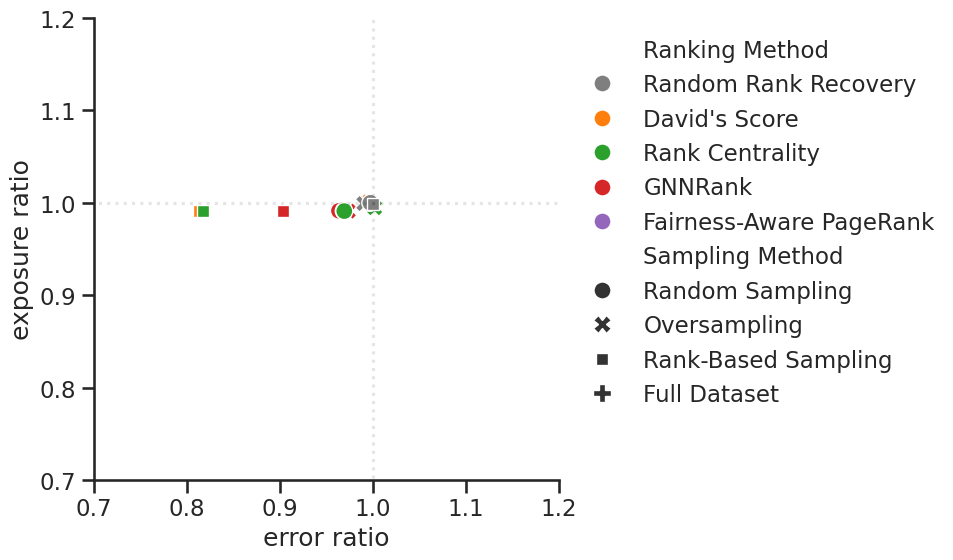

In [34]:
palette = sns.color_palette('tab10')
palette[0] = palette[7]
sns.set(rc={'figure.figsize':(6,6)})
sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = overall_df[(overall_df.bias_applied)].copy()# & (overall_df['Sampling Method'] == 'Random Sampling')]
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank']
sampling_methods = ['Random Sampling', 'Oversampling', 'Rank-Based Sampling', 'Full Dataset']
df = df[df['Ranking Method'].isin(ranking_methods)]
#df['exposure ratio'] = df['exposure ratio'] + np.random.normal(0,0.001,len(df))
#df['error ratio'] = df['error ratio'] + np.random.normal(0,0.001,len(df))
#df['error'] = df['error'] + np.random.normal(0,0.001,len(df))

with sns.color_palette(palette):
    ax = sns.scatterplot(df, x='error ratio', y='exposure ratio', hue='Ranking Method', s=150, style='Sampling Method',
                         hue_order=ranking_methods,
                         style_order=sampling_methods)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(xlim=(0.7,1.2), ylim=(0.7,1.2))
plt.plot([0,2], [1,1], color='black', linestyle='dotted', alpha=0.1)
plt.plot([1,1], [0,2], color='black', linestyle='dotted', alpha=0.1)
sns.despine()

## Seperate 1D Plots

In [35]:
sel_df2 = raw_df[(raw_df.iteration == 500) & (raw_df.bias_applied == True)].drop(columns=['iteration', 'bias_applied'])
sel_df2 = sel_df2.pivot(index=['trial', 'sampling method', 'Ranking Method'], columns=['metric', 'group'], values='value').reset_index()
sel_df2

metric trial     sampling method  \
group                              
0          0  OversampleMinority   
1          0  OversampleMinority   
2          0  OversampleMinority   
3          0  OversampleMinority   
4          0  OversampleMinority   
..       ...                 ...   
145        9        RankSampling   
146        9        RankSampling   
147        9        RankSampling   
148        9        RankSampling   
149        9        RankSampling   

metric                                 Ranking Method       tau             \
group                                                   Overall Privileged   
0       Fairness-Aware PageRank\n(not post-processed)  0.239686   0.251504   
1                                             GNNRank  0.272950   0.304390   
2                                          davidScore  0.277134   0.312949   
3                                  randomRankRecovery  0.785330   0.794892   
4                                      rankCentrality  0.302289   0.335071   
..                                                ...       ...        ...   
145     Fairness-Aware PageRank\n(not post-processed)  0.312508   0.313939   
146                                           GNNRank  0.326861   0.333338   
147                                        davidScore  0.419418   0.394367   
148                                randomRankRecovery  0.705435   0.690964   
149                                    rankCentrality  0.361320   0.335155   

metric                                                      \
group  Unprivileged Privileged within-group Between groups   
0          0.229068                0.267291       0.242812   
1          0.304646                0.116724       0.359383   
2          0.303025                0.160100       0.361396   
3          0.775703                0.814794       0.785120   
4          0.339349                0.136172       0.397855   
..              ...                     ...            ...   
145        0.309595                0.320455       0.310465   
146        0.386931                0.074139       0.416960   
147        0.463865                0.162321       0.457397   
148        0.720190                0.661676       0.705721   
149        0.408554                0.148007       0.397022   

metric                             exposure               
group  Unprivileged within-group Privileged Unprivileged  
0                       0.197043   0.142876     0.153184  
1                       0.158072   0.148689     0.147371  
2                       0.141077   0.147641     0.148419  
3                       0.756968   0.148562     0.147499  
4                       0.171876   0.147564     0.148497  
..                           ...        ...          ...  
145                     0.307682   0.142504     0.153556  
146                     0.299941   0.148619     0.147441  
147                     0.474748   0.148744     0.147316  
148                     0.749455   0.147745     0.148316  
149                     0.430837   0.148678     0.147382  

[150 rows x 11 columns]

In [36]:
sel_df3 = sel_df2.copy()
sel_df3['exposure ratio'] = sel_df3['exposure']['Unprivileged'] / sel_df3['exposure']['Privileged']
sel_df3['error ratio'] = sel_df3['tau']['Unprivileged'] / sel_df3['tau']['Privileged']
sel_df3['exposure difference'] = sel_df3['exposure']['Unprivileged'] - sel_df3['exposure']['Privileged']
sel_df3['error difference'] = sel_df3['tau']['Unprivileged'] - sel_df3['tau']['Privileged']
sel_df3['error'] = sel_df3['tau']['Overall']
sel_df3 = sel_df3[['trial', 'sampling method', 'Ranking Method', 'exposure ratio', 'error ratio', 'error', 'error difference', 'exposure difference']].droplevel('group', axis=1)
sel_df3 = sel_df3.replace({'OversampleMinority': 'Oversampling',
                            'oversampling': 'Oversampling',
                            'RankSampling': 'Rank-Based Sampling',
                            'rankSampling': 'Rank-Based Sampling',
                            'RandomSampling': 'Random Sampling',
                            'randomSampling': 'Random Sampling',
                            'fairPageRank': 'Fairness-Aware PageRank',
                            'davidScore': "David's Score",
                            'randomRankRecovery': 'Random Rank Recovery',
                            'rankCentrality': 'Rank Centrality',
                            'full dataset': 'Full Dataset'})

sel_df3 = sel_df3.rename(columns={'sampling method': 'Sampling Method'})
sel_df3

metric,trial,Sampling Method,Ranking Method,exposure ratio,error ratio,error,error difference,exposure difference
0,0,Oversampling,Fairness-Aware PageRank\n(not post-processed),1.072143,0.910795,0.239686,-0.022436,0.010307
1,0,Oversampling,GNNRank,0.991134,1.000843,0.272950,0.000257,-0.001318
2,0,Oversampling,David's Score,1.005272,0.968288,0.277134,-0.009924,0.000778
3,0,Oversampling,Random Rank Recovery,0.992844,0.975859,0.785330,-0.019189,-0.001063
4,0,Oversampling,Rank Centrality,1.006321,1.012766,0.302289,0.004277,0.000933
...,...,...,...,...,...,...,...,...
145,9,Rank-Based Sampling,Fairness-Aware PageRank\n(not post-processed),1.077553,0.986163,0.312508,-0.004344,0.011052
146,9,Rank-Based Sampling,GNNRank,0.992071,1.160778,0.326861,0.053593,-0.001178
147,9,Rank-Based Sampling,David's Score,0.990396,1.176225,0.419418,0.069497,-0.001428
148,9,Rank-Based Sampling,Random Rank Recovery,1.003865,1.042298,0.705435,0.029227,0.000571


In [37]:
# Okabe-Ito color palette
lightblue = "#56B4E9"
yellow = "#F0E442"
orange = "#E69F00"
green = "#009E73"
purple = "#CC79A7"
red = "#D55E00"
blue = "#0072B2"
black = "#000000"
#palette = [black, orange, lightblue, green, yellow, blue, red, purple] # original order
palette = [black, orange, lightblue, green, red, purple] # custom order

#palette = sns.color_palette('tab10')
#palette[0] = palette[7]

sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = sel_df3
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank\n(not post-processed)']

df = df.replace({
    'Random Rank Recovery': 'Random Rank Recovery\n& EPIRA',
    'David\'s Score': 'David\'s Score\n& EPIRA',
    'Rank Centrality': 'Rank Centrality\n& EPIRA',
    'GNNRank': 'GNNRank\n& EPIRA'
})
ranking_methods = ['Random Rank Recovery\n& EPIRA', "David's Score\n& EPIRA", 'Rank Centrality\n& EPIRA', 'GNNRank\n& EPIRA', 'Fairness-Aware PageRank\n(not post-processed)']

sampling_methods = ['Full Dataset', 'Random Sampling', 'Oversampling', 'Rank-Based Sampling']
metrics = ['exposure difference', 'error difference', 'error']

df = df[df['Ranking Method'].isin(ranking_methods)]
df = df.melt(id_vars=['Sampling Method', 'Ranking Method'], value_vars=['error', 'exposure difference', 'error difference'])

df['metric_order'] = df.metric.map(metrics.index)
df['sampling_order'] = df['Sampling Method'].map(sampling_methods.index)
df['ranking_order'] = df['Ranking Method'].map(list(reversed(ranking_methods)).index)
df = df.sort_values(by=['ranking_order', 'sampling_order', 'metric_order']).drop(columns=['ranking_order', 'sampling_order', 'metric_order'])

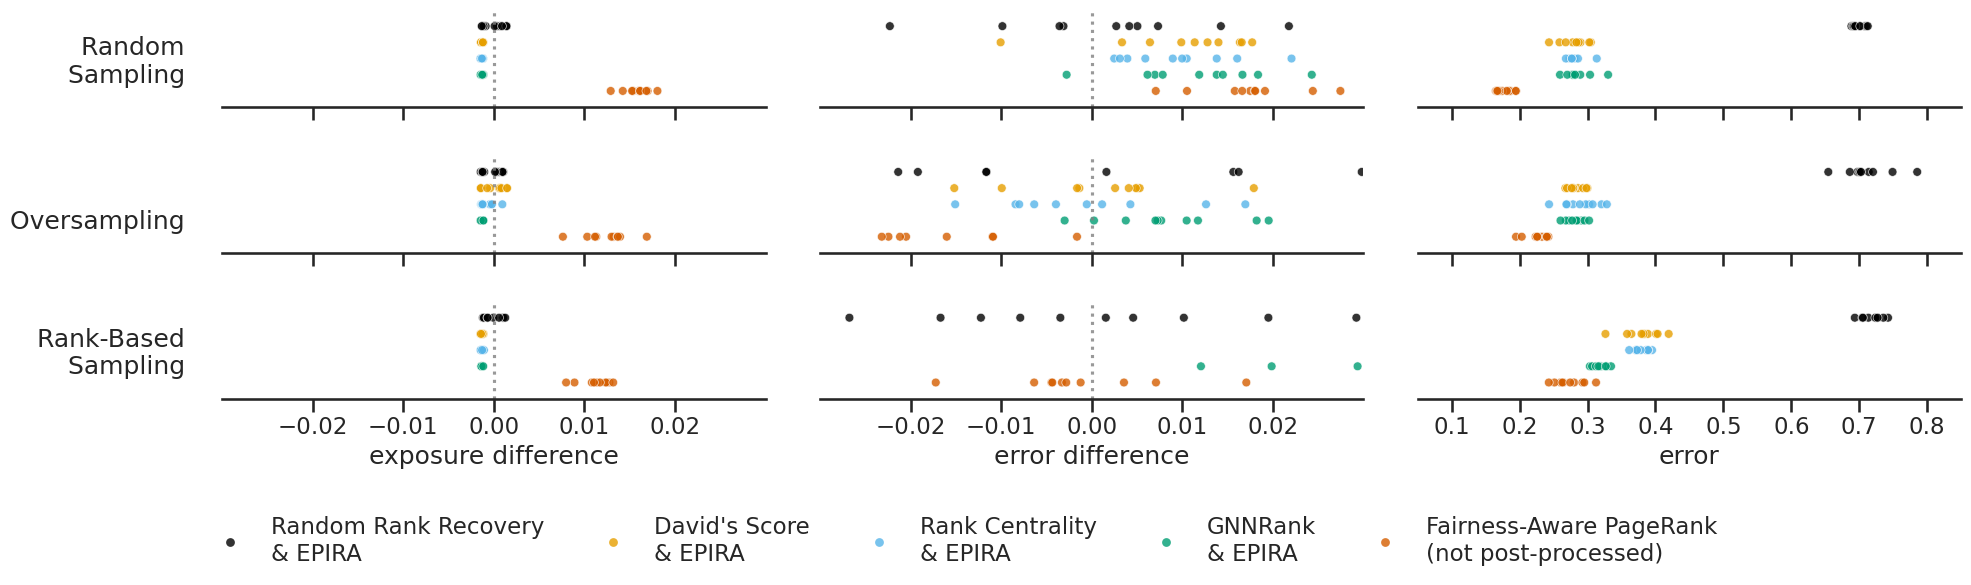

In [38]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.relplot(df, x='value', y='Ranking Method', hue='Ranking Method', kind='scatter', #style='Sampling Method',
                    row='Sampling Method', col='metric',
                    hue_order=ranking_methods, style_order=sampling_methods,
                    s=40, alpha=0.8, aspect=4/1, height=1.8, facet_kws={'sharey': True, 'sharex': False})

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.13, 0))#
g.refline(x=0, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((-1,5))
    
    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])

    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
    else:
        ax.set(xlim=(-0.03,0.03))
        ax.set_xticks([-0.02,-0.01,0,0.01,0.02])
    
    if col_val == 'exposure difference':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)

sns.despine(left=True)
#plt.savefig('./data/others_results/combined_results_1D.png', dpi=300, bbox_inches="tight")

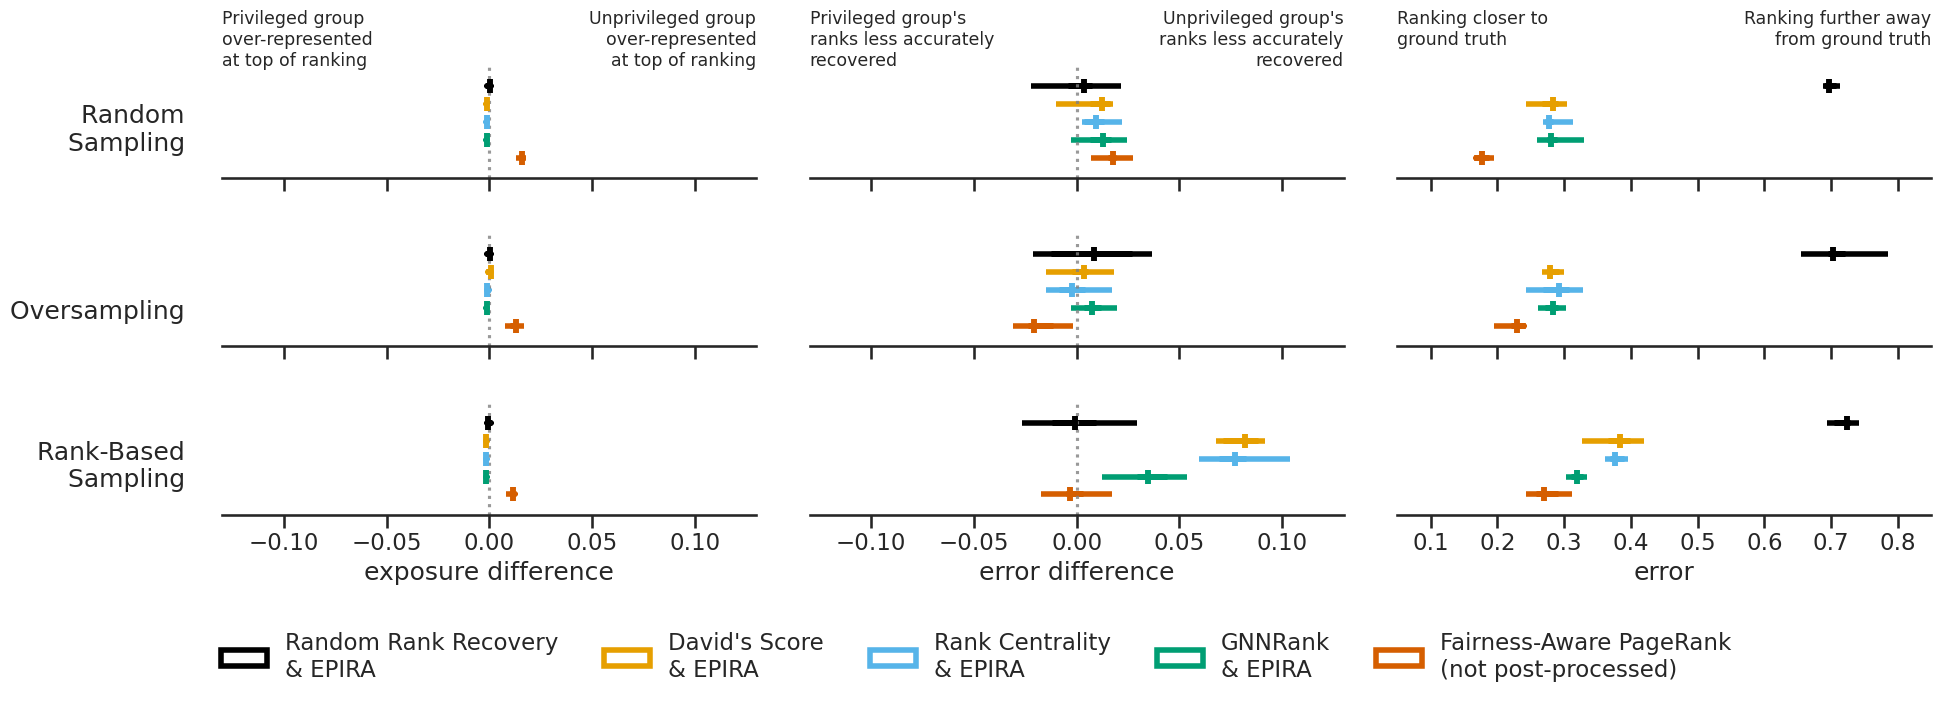

In [39]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.catplot(df, x='value', kind='box', #style='Sampling Method',
                    row='Sampling Method', col='metric', hue='Ranking Method',
                    hue_order=ranking_methods, sharex=False, sharey=True,
                    aspect=3/1, height=2,
                    # sns.boxplot properties
                    fill=False, whis=(0, 100), linewidth=4,
                    # plt.boxplot properties & Line2D properties
                    medianprops={'marker': '|', 'markeredgewidth': 4, 'markersize': 10}, showcaps=False,
                    #showmeans=True, meanprops={'marker': '|', 'markeredgecolor': 'black', 'markeredgewidth': 2, 'markersize': 10},
                    widths=0)
    # s=40, alpha=0.8, facet_kws={'sharey': True, 'sharex': False}, height=1.8

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.008, 0))

g.refline(x=0, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((0.5,-0.5))
    
    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
        #ax.set_xscale('log', base=10)
        pass
    else:
        #log_lim = 0.86
        #log_lim = 0.65
        #ax.set(xlim=(log_lim,1/log_lim))
        #ax.set_xscale('log', base=10)
        #ticks = [.9,.95,1,1.05,1.1,1.15]
        #ticks = [0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
        #ticklabels = [0.7,0.8,0.9,1,'',1.2,'',1.4]
        #ax.set_xticks(ticks)
        #ax.set_xticklabels(ticklabels)
        #ax.set(xlim=(-0.025,0.025))
        #ax.set_xticks([-0.02,-0.01,0,0.01,0.02])
        ax.set(xlim=(-0.13,0.13))
        ax.set_xticks([-0.1,-0.05,0,0.05,0.1])

    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])
    
    if col_val == 'exposure difference':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)
    
    if row_val == 'Random Sampling':
        y = -.5
        y_offset = -.5
        lim = -0.13 #0.65
        inv_lim = 0.13 #1/lim
        if col_val == 'exposure difference':
            ax.annotate('Privileged group\nover-represented\nat top of ranking',
                        xy=(lim, y), xytext=(lim,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Unprivileged group\nover-represented\nat top of ranking',
                        xy=(inv_lim, y), xytext=(inv_lim,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')
        elif col_val == 'error difference':
            ax.annotate('Privileged group\'s\nranks less accurately\nrecovered',
                        xy=(lim, y), xytext=(lim,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Unprivileged group\'s\nranks less accurately\nrecovered',
                        xy=(inv_lim, y), xytext=(inv_lim,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')
        elif col_val == 'error':
            ax.annotate('Ranking closer to\nground truth',
                        xy=(0.05, y), xytext=(0.05,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Ranking further away\nfrom ground truth',
                        xy=(.85, y), xytext=(0.85,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')

sns.despine(left=True)
plt.savefig('./data/combined_plots/EPIRA99_results_fairPR_diff_short_v2.png', dpi=300, bbox_inches="tight")